In [1]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Sequence, Tuple

plt.style.use("seaborn-v0_8-colorblind")

Array = np.ndarray
DerivativeFn = Callable[[float, Array, Dict[str, float]], Array]


In [2]:

def rk4_step(derivatives: DerivativeFn,
             t: float,
             state: Array,
             dt: float,
             params: Dict[str, float]) -> Array:
    """Advance one Runge-Kutta 4 step for the provided ODE system."""
    k1 = derivatives(t, state, params)
    k2 = derivatives(t + 0.5 * dt, state + 0.5 * dt * k1, params)
    k3 = derivatives(t + 0.5 * dt, state + 0.5 * dt * k2, params)
    k4 = derivatives(t + dt, state + dt * k3, params)
    update = (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    return state + dt * update


def simulate_model(derivatives: DerivativeFn,
                   initial_state: Sequence[float],
                   t_eval: Array,
                   params: Dict[str, float]) -> Tuple[Array, Array]:
    """Integrate an ODE system for the requested time grid using RK4."""
    initial_state = np.asarray(initial_state, dtype=float)
    states = np.zeros((len(t_eval), initial_state.size))
    states[0] = initial_state
    state = initial_state.copy()

    for idx in range(1, len(t_eval)):
        dt = t_eval[idx] - t_eval[idx - 1]
        state = rk4_step(derivatives, t_eval[idx - 1], state, dt, params)
        state = np.clip(state, a_min=0.0, a_max=None)
        states[idx] = state

    return t_eval, states


def compute_cumulative_infections(times: Array,
                                 states: Array,
                                 params: Dict[str, float]) -> float:
    """Approximate total infections using the σE flux integral."""
    sigma = params.get("sigma")
    if sigma is None:
        raise ValueError("sigma must be provided to compute cumulative infections in the SEIR model")
    exposed = states[:, 1]
    return np.trapz(sigma * exposed, x=times)


In [3]:

TOTAL_POP = 1000
BETA_SPEC = 0.3e-3  # Value provided in the PDF (per person)


def sir_derivatives(_: float, state: Array, params: Dict[str, float]) -> Array:
    S, I, R = state
    beta = params["beta"]
    gamma = params["gamma"]
    N = params.get("N", S + I + R)
    infection_term = beta * S * I / N
    dS = -infection_term
    dI = infection_term - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])


sir_params = {"beta": BETA_SPEC * TOTAL_POP, "gamma": 0.1, "N": TOTAL_POP}
sir_initial_state = (999.0, 1.0, 0.0)
sir_times = np.linspace(0.0, 150.0, 1501)  # 0.1 day resolution
sir_times, sir_states = simulate_model(sir_derivatives, sir_initial_state, sir_times, sir_params)
S_sir, I_sir, R_sir = sir_states.T

sir_peak_idx = np.argmax(I_sir)
sir_peak_day = float(sir_times[sir_peak_idx])
sir_peak_size = float(I_sir[sir_peak_idx])
sir_R0 = sir_params["beta"] / sir_params["gamma"]

print(f"SIR infection peak: day {sir_peak_day:.1f} with {sir_peak_size:.1f} concurrent infections")
print(f"Basic reproductive number R0 = {sir_R0:.2f}")


SIR infection peak: day 38.4 with 300.8 concurrent infections
Basic reproductive number R0 = 3.00


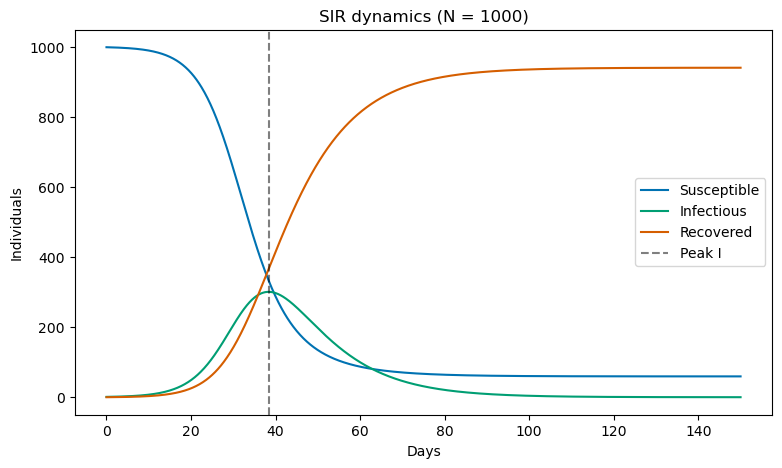

In [4]:

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(sir_times, S_sir, label="Susceptible")
ax.plot(sir_times, I_sir, label="Infectious")
ax.plot(sir_times, R_sir, label="Recovered")
ax.axvline(sir_peak_day, color="k", linestyle="--", alpha=0.5, label="Peak I")
ax.set_xlabel("Days")
ax.set_ylabel("Individuals")
ax.set_title("SIR dynamics (N = 1000)")
ax.legend()
plt.show()


In [5]:

def seir_derivatives(_: float, state: Array, params: Dict[str, float]) -> Array:
    S, E, I, R = state
    beta = params["beta"]
    gamma = params["gamma"]
    sigma = params["sigma"]
    mu = params["mu"]
    N = params.get("N", S + E + I + R)

    infection_term = beta * S * I / N
    dS = mu * N - infection_term - mu * S
    dE = infection_term - (sigma + mu) * E
    dI = sigma * E - (gamma + mu) * I
    dR = gamma * I - mu * R
    return np.array([dS, dE, dI, dR])


seir_params = {
    "beta": BETA_SPEC * TOTAL_POP,
    "gamma": 0.1,
    "sigma": 0.2,
    "mu": 0.01,
    "N": TOTAL_POP,
}
seir_initial_state = (990.0, 9.0, 1.0, 0.0)


def run_seir_simulation(days: int, params: Dict[str, float]) -> Tuple[Array, Array]:
    times = np.arange(0.0, days + 0.1, 0.1)
    return simulate_model(seir_derivatives, seir_initial_state, times, params)


seir_times_365, seir_states_365 = run_seir_simulation(365, seir_params)
seir_times_1200, seir_states_1200 = run_seir_simulation(1200, seir_params)


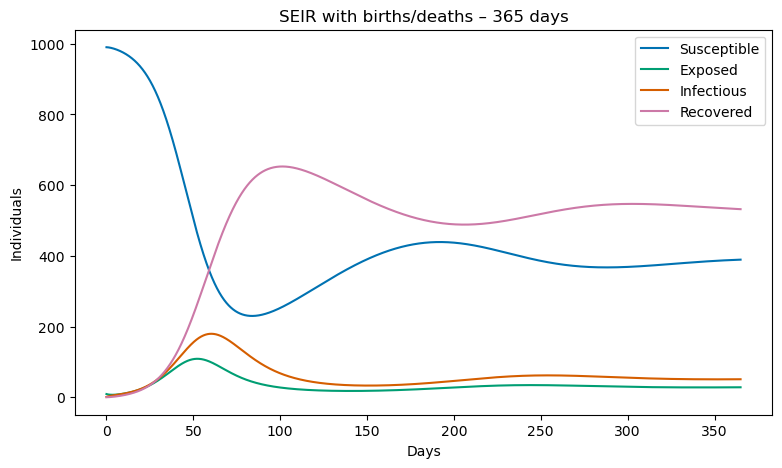

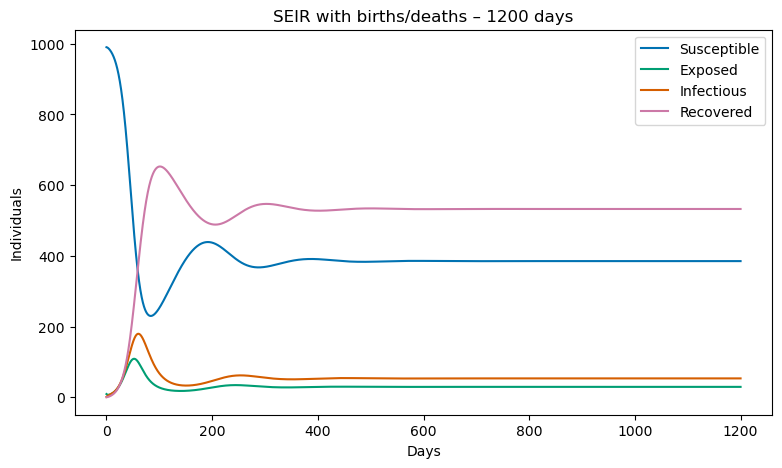

In [6]:

def plot_compartments(times: Array, states: Array, title: str) -> None:
    fig, ax = plt.subplots(figsize=(9, 5))
    labels = ["Susceptible", "Exposed", "Infectious", "Recovered"]
    for idx, label in enumerate(labels):
        ax.plot(times, states[:, idx], label=label)
    ax.set_xlabel("Days")
    ax.set_ylabel("Individuals")
    ax.set_title(title)
    ax.legend()
    plt.show()


plot_compartments(seir_times_365, seir_states_365, "SEIR with births/deaths – 365 days")
plot_compartments(seir_times_1200, seir_states_1200, "SEIR with births/deaths – 1200 days")


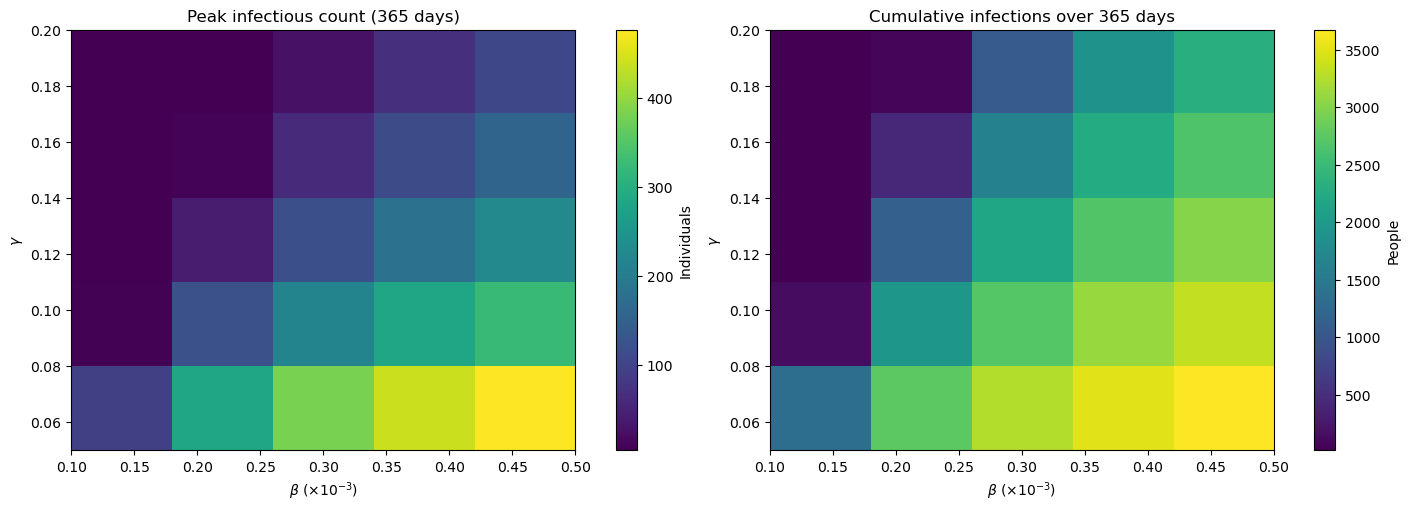

In [7]:

beta_range = np.linspace(0.1e-3, 0.5e-3, 5)
gamma_range = np.linspace(0.05, 0.2, 5)
peak_infections = np.zeros((len(gamma_range), len(beta_range)))
total_infections = np.zeros_like(peak_infections)

for i, gamma_val in enumerate(gamma_range):
    for j, beta_val in enumerate(beta_range):
        params = {**seir_params, "gamma": gamma_val, "beta": beta_val * TOTAL_POP}
        times, states = run_seir_simulation(365, params)
        I_curve = states[:, 2]
        peak_infections[i, j] = I_curve.max()
        total_infections[i, j] = compute_cumulative_infections(times, states, params)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

im0 = axes[0].imshow(peak_infections, origin="lower", aspect="auto",
                     extent=[beta_range[0]*1e3, beta_range[-1]*1e3,
                             gamma_range[0], gamma_range[-1]])
axes[0].set_title("Peak infectious count (365 days)")
axes[0].set_xlabel(r"$\beta$ ($\times 10^{-3}$)")
axes[0].set_ylabel(r"$\gamma$")
fig.colorbar(im0, ax=axes[0], label="Individuals")

im1 = axes[1].imshow(total_infections, origin="lower", aspect="auto",
                     extent=[beta_range[0]*1e3, beta_range[-1]*1e3,
                             gamma_range[0], gamma_range[-1]])
axes[1].set_title("Cumulative infections over 365 days")
axes[1].set_xlabel(r"$\beta$ ($\times 10^{-3}$)")
axes[1].set_ylabel(r"$\gamma$")
fig.colorbar(im1, ax=axes[1], label="People")
plt.show()
